In [2]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np
!pip install torchinfo
from torchinfo import summary

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Defaulting to user installation because normal site-packages is not writeable


In [13]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 512),
#       # nn.Sigmoid(), # 
#       nn.ReLU(),
#       nn.Linear(512,128),
#       # nn.Sigmoid(), # 
#       nn.ReLU(),
#       nn.Linear(128, 10)   # 10 car le nombre de classes = 10
#     )

#   def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
#     '''Forward pass'''
#     return self.layers(x)


# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )

#   def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
#     '''Forward pass'''
#     return self.layers(x)

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
      nn.Linear(input_features, 216),
      nn.ReLU(), #nn.Sigmoid(),
      nn.Linear(216,10)
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)

# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 1024),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(1024,512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )


In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Début de la boucle d'entraînement
    size = len(dataloader.dataset)  # Taille totale du jeu de données
    nb_batches = len(dataloader)     # Nombre total de lots dans le jeu de données
    epoch_loss = 0                   # Initialisation de la perte totale pour l'époque

    for batch, (X, y) in enumerate(dataloader):
        # X : données d'entrée, y : étiquettes correspondantes

        # Calcul de la prédiction du modèle et de la perte
        pred = model(X.float())  # Utilisation du modèle pour prédire les sorties
        loss = loss_fn(pred, y)  # Calcul de la perte entre les prédictions et les étiquettes réelles
        epoch_loss += loss.item()  # Ajout de la perte de ce lot à la perte totale de l'époque

        # Rétropropagation (Backpropagation)
        optimizer.zero_grad()  # Réinitialisation des gradients accumulés dans les paramètres du modèle
        loss.backward()       # Calcul des gradients par rétropropagation
        optimizer.step()       # Mise à jour des paramètres du modèle en fonction des gradients

    # Calcul de la perte moyenne pour l'époque et affichage
    average_loss = epoch_loss / nb_batches
    #print(f"\nPerte d'entraînement :", average_loss)

    # Retourne la perte moyenne pour l'époque
    return average_loss

def valid_loop(dataloader, model, loss_fn):
    # Début de la boucle de validation
    size = len(list(dataloader.dataset))  # Taille totale du jeu de données de validation
    nb_batches = len(dataloader)           # Nombre total de lots dans le jeu de données
    valid_loss = 0                         # Initialisation de la perte de validation

    with torch.no_grad():
        # Désactive le calcul des gradients pendant la validation
        for X, y in dataloader:
            # X : données d'entrée, y : étiquettes correspondantes

            # Calcul de la prédiction du modèle et de la perte
            pred = model(X.float())  # Utilisation du modèle pour prédire les sorties
            valid_loss += loss_fn(pred, y).item()  # Ajout de la perte de ce lot à la perte totale de validation

    # Calcul de la perte moyenne de validation et affichage
    valid_loss /= nb_batches
    #print("Perte de validation :", valid_loss)

    # Retourne la perte moyenne de validation
    return valid_loss

def perf_loop(dataloader, model):
    # Début de la boucle de performance
    Total = len(list(dataloader.dataset))  # Nombre total d'exemples dans le jeu de données de test
    nb_batches = len(dataloader)            # Nombre total de lots dans le jeu de données
    Positifs = 0                            # Initialisation du compteur de prédictions correctes

    with torch.no_grad():
        # Désactive le calcul des gradients pendant la performance
        for X, y in dataloader:
            # X : données d'entrée, y : étiquettes correspondantes

            # Calcul de la prédiction du modèle
            pred = model(X.float())  # Utilisation du modèle pour prédire les sorties

            # Calcul des probabilités de classe avec Softmax
            prob_pred = nn.Softmax(dim=1)(pred)

            # Prédiction de la classe avec la probabilité maximale
            y_pred = torch.argmax(prob_pred, dim=1)

            # Comparaison des prédictions avec les étiquettes réelles
            similaires = np.array(y_pred == y)
            Positifs += np.sum(similaires)

    # Retourne le nombre total de prédictions correctes, le nombre total d'exemples, et la dernière prédiction
    return Positifs, Total, y_pred

def affichage(dataloader, message):
  fig1, axs1 = plt.subplots(1,6,figsize=(6,1))
  image_batch, label_batch = next(iter(dataloader))
  for i in range(6):
    image = image_batch[i].squeeze().numpy() # squeeze les dimensions de longueur 1 : ici la dimension du canal de l'image
    message += str(label_batch[i].numpy())+" "
    plt.subplot(1,6,i+1)
    plt.imshow(image, cmap="gray")
  print(message)
  plt.show()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
torch.manual_seed(42) #Set fixed random number seed

# Prepare MNIST dataset
dataset = MNIST(os.getcwd(), train = True, download=True, transform=transforms.ToTensor())
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/ENT-UR/AUTOFS/STUDENTS/coelhrod/Git/Apprentissage profond/TP2
    Split: Train
    StandardTransform
Transform: ToTensor()

Train :5 7 1 5 0 2 


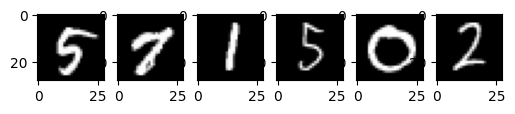

Valid :1 2 2 6 4 5 


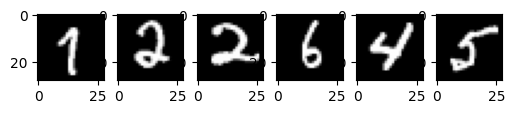

In [14]:
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 64 # 128
EPOCHS = 60 # 60
LEARNING_RATE = 1e-3 # 1e-3
OPTIM = "ADAM" # "SGD" #  "ADAM"
Model_name = "Mon_meilleur_MLP"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
affichage(trainloader,"Train :")
affichage(validloader,"Valid :")

In [15]:
dim = 28 * 28
summary(model=MLP(input_features = dim),
        input_size=(BATCH_SIZE, 1, 28, 28), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLP (MLP)                                [64, 1, 28, 28]      [64, 10]             --                   True
├─Sequential (layers)                    [64, 1, 28, 28]      [64, 10]             --                   True
│    └─Flatten (0)                       [64, 1, 28, 28]      [64, 784]            --                   --
│    └─Linear (1)                        [64, 784]            [64, 216]            169,560              True
│    └─ReLU (2)                          [64, 216]            [64, 216]            --                   --
│    └─Linear (3)                        [64, 216]            [64, 10]             2,170                True
Total params: 171,730
Trainable params: 171,730
Non-trainable params: 0
Total mult-adds (M): 10.99
Input size (MB): 0.20
Forward/backward pass size (MB): 0.12
Params size (MB): 0.69
Estimated Total Size (MB): 1.00

  3%|▎         | 2/60 [00:04<01:58,  2.05s/it]

best validation loss : 0.13236319325230222


  5%|▌         | 3/60 [00:06<01:56,  2.04s/it]

best validation loss : 0.10653076687471029


  7%|▋         | 4/60 [00:08<01:54,  2.04s/it]

best validation loss : 0.10265980407278588


  8%|▊         | 5/60 [00:10<01:51,  2.03s/it]

best validation loss : 0.09110855738176628


 10%|█         | 6/60 [00:12<01:48,  2.02s/it]

best validation loss : 0.08515098489365204


 12%|█▏        | 7/60 [00:14<01:46,  2.02s/it]

best validation loss : 0.08264854317035605


 15%|█▌        | 9/60 [00:18<01:42,  2.01s/it]

best validation loss : 0.079994989380716


100%|██████████| 60/60 [01:56<00:00,  1.95s/it]

Apprentisage terminé.



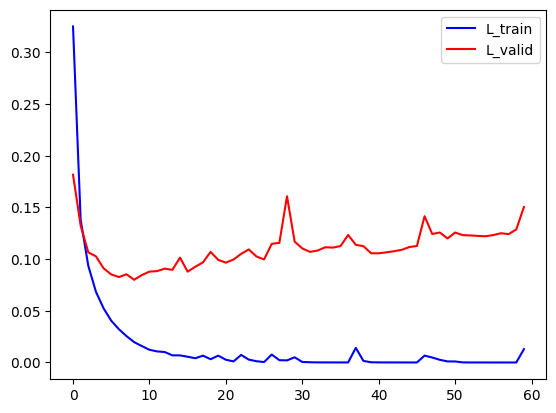

In [16]:
#################  Instanciation du MLP #################
dim = 28 * 28  # dimension des images MNIST
my_MLP = MLP(input_features = dim)
my_loss = nn.CrossEntropyLoss()
if OPTIM == "SGD":
    my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
elif OPTIM == "ADAM":
    my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
else:
    print("Optimiseur inconnu !!!!")

############      BOUCLES D'APPRENTISSAGE     ###########
train_loss = []
valid_loss = []
for t in tqdm(range(EPOCHS)):
    train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
    # on test à chaque itération
    valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
    # mettre ici le Early Stopping
    if t == 0:
        best_valid_loss = valid_loss[-1]
    else:
        if valid_loss[-1] < best_valid_loss:
            best_valid_loss = valid_loss[-1]
            print(f"best validation loss : {best_valid_loss}")
            # on mémorise ce modèle
            best_iter = t
            torch.save(my_MLP.state_dict(), Model_name)

print('Apprentisage terminé.\n')

# visu des loss train et test
plt.figure()
plt.plot(train_loss,"b",label="L_train")
plt.plot(valid_loss,"r",label="L_valid")
plt.legend()

Test :7 2 1 0 4 1 


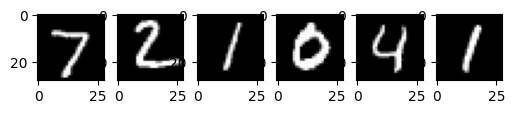

/tmp/ipykernel_20628/3187708192.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_best_MLP.load_state_dict(torch.load(Model_name))


Taux de reco en Test: 9776 / 10000 = 97.76 % de réussite
Meilleure époque : 9
Nombre de paramètres libres: 171730


/tmp/ipykernel_20628/1268584892.py:70: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  similaires = np.array(y_pred == y)


In [17]:
############## on teste maintenaant les performances ################
test_dataset = MNIST(os.getcwd(), train = False, download=True, transform=transforms.ToTensor())
N_test = len(test_dataset)

##############
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=N_test, shuffle=False, num_workers=1)
affichage(testloader,"Test :")

my_best_MLP = MLP(input_features = dim)
my_best_MLP.load_state_dict(torch.load(Model_name))
Positifs, Total, y_pred = perf_loop(testloader, my_best_MLP)
print("Taux de reco en Test:",Positifs,"/", Total, "=", (Positifs/Total)*100, "% de réussite")
print("Meilleure époque :",best_iter+1)

nb_train_param = count_parameters(my_best_MLP)
print("Nombre de paramètres libres:",nb_train_param)